# Logging to a GSD file

## Overview

### Questions

* What is a Logger?
* How can I write thermodynamic and other quantities to a file?
* How can I access that data?

### Objectives

* Describe and give examples of **loggable quantities**.
* Show how to add quantities to a **Logger**.
* Demonstrate **GSD** as a log writer.
* Explain how to read logged quantities from **GSD** files.
* Describe how **namespaces** appear in the names of the logged quantities.

## Boilerplate code

In [1]:
import gsd.hoomd
import hoomd
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import os

fn = os.path.join(os.getcwd(), 'log.gsd')
![ -e "$fn" ] && rm "$fn"

## Introduction

HOOMD separates logging into three parts: **Loggable quantities**, the **Logger** class, and 
**Writers**.

* **Loggable quantities** are values computed during a simulation.
* The **Logger** class provides a way to collect and name quantities of interest.
* **Writers** write these values out in a format you can use.

In this section, you will use the **GSD Writer** to capture the values of quantities during a simulation run for later analysis.

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from a previous tutorial. 
See [*Introducing Molecular Dyamics*](../01-Introducing-Molecular-Dynamics/00-index.ipynb) for a complete description of this code.

In [3]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=1)
sim.create_state_from_gsd(
    filename='../01-Introducing-Molecular-Dynamics/random.gsd')

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(),
    thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5))
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.run(0)

## Loggable quantities

Many classes in HOOMD-blue provide special *properties* called **loggable quantities**.
For example, the **Simulation** class provides `timestep`, `tps`, and others.
The reference documentation labels each of these as _Loggable_.
You can also examine the ``loggables`` property to determine the **loggable quantities**:

In [4]:
sim.loggables

{'timestep': 'scalar',
 'seed': 'scalar',
 'tps': 'scalar',
 'walltime': 'scalar',
 'final_timestep': 'scalar',
 'initial_timestep': 'scalar'}

The **ThermodynamicQuantities** class computes a variety of **thermodynamic properties** in MD simulations.
These are all loggable.

In [5]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())
sim.operations.computes.append(thermodynamic_properties)
thermodynamic_properties.loggables

{'kinetic_temperature': 'scalar',
 'pressure': 'scalar',
 'pressure_tensor': 'sequence',
 'kinetic_energy': 'scalar',
 'translational_kinetic_energy': 'scalar',
 'rotational_kinetic_energy': 'scalar',
 'potential_energy': 'scalar',
 'degrees_of_freedom': 'scalar',
 'translational_degrees_of_freedom': 'scalar',
 'rotational_degrees_of_freedom': 'scalar',
 'num_particles': 'scalar',
 'volume': 'scalar'}

**Loggable quantities** are class properties or methods.
You can directly access them in your code.

In [6]:
sim.timestep

10000

In [7]:
thermodynamic_properties.kinetic_temperature

1.590511952800884

Each **loggable quantity** has a **category**, which is listed both in the reference documentation and in ``loggables``.
The **category** is a string that identifies the quantity's type or category.
Example categories include:
* `scalar` - numbers
* `sequence` - arrays of numbers
* `string` - strings of characters
* `particle` - arrays of per-particle values

## Add quantities to a Logger

Add each of the quantities you would like to store to a **Logger**.
The **Logger** will maintain these quantities in a list and provide them to the **Writer** when needed.

In [8]:
logger = hoomd.logging.Logger()

You can add **loggable quantities** from any number of objects to a **Logger**.
**Logger** uses the namespace of the class to assign a unique name for each quantity.
Call `add` to add all quantities provided by `thermodynamic_properties`:

In [9]:
logger.add(thermodynamic_properties)

You can also select specific quantities to add with the `quantities` argument.
Add only the `timestep` and `walltime` quantities from **Simulation**:

In [10]:
logger.add(sim, quantities=['timestep', 'walltime'])

## Writing log quantities to a GSD file

**GSD** files always store trajectories of particle properties.
Set the `logger` attribute and **GSD** will also store the selected quantities.

You can store _only_ the logged quantities by using the **Null** filter to select no particles for the trajectory.
This way, you can log thermodynamic properties at a high rate and keep the file size small.


In [11]:
gsd_writer = hoomd.write.GSD(filename='log.gsd',
                             trigger=hoomd.trigger.Periodic(1000),
                             mode='xb',
                             filter=hoomd.filter.Null())
sim.operations.writers.append(gsd_writer)

Assign the logger to include the logged quanties in the GSD file:

In [12]:
gsd_writer.logger = logger

The writer triggers and writes to the log file when the simulation runs:

In [13]:
sim.run(100000)

Flush the GSD buffer so it is readable in the next code cell. In typical workflows, you will run separate simulation and analysis scripts and the **GSD** file will flush when your simulation script exits.

In [14]:
gsd_writer.flush()

## Reading logged data from a GSD file

Use the `gsd` package to open read the logged data from the file as a time series:

In [15]:
data = gsd.hoomd.read_log('log.gsd')

The data is given as a dictionary of logged quantities:

In [16]:
list(data.keys())

['configuration/step',
 'log/md/compute/ThermodynamicQuantities/kinetic_temperature',
 'log/md/compute/ThermodynamicQuantities/pressure',
 'log/md/compute/ThermodynamicQuantities/pressure_tensor',
 'log/md/compute/ThermodynamicQuantities/kinetic_energy',
 'log/md/compute/ThermodynamicQuantities/translational_kinetic_energy',
 'log/md/compute/ThermodynamicQuantities/rotational_kinetic_energy',
 'log/md/compute/ThermodynamicQuantities/potential_energy',
 'log/md/compute/ThermodynamicQuantities/degrees_of_freedom',
 'log/md/compute/ThermodynamicQuantities/translational_degrees_of_freedom',
 'log/md/compute/ThermodynamicQuantities/rotational_degrees_of_freedom',
 'log/md/compute/ThermodynamicQuantities/num_particles',
 'log/md/compute/ThermodynamicQuantities/volume',
 'log/Simulation/timestep',
 'log/Simulation/walltime']

The dictionary keys are verbose names that include the **namespace** of the class which computed the quantity, where `.` has been replaced with `/`.
For example, access the potential energy computed by **ThermodynamicQuantities** with the key `log/md/compute/ThermodynamicQuantities/potential_energy`.

In [17]:
data['log/md/compute/ThermodynamicQuantities/potential_energy']

array([-541.16848184, -538.2510157 , -555.92434656, -545.85893653,
       -535.23006039, -517.12432502, -544.13966979, -526.39814447,
       -555.8345156 , -537.94766979, -528.2843952 , -586.89526502,
       -541.78340471, -551.94749262, -540.15786035, -553.39114322,
       -549.19073356, -533.78995747, -490.44927437, -541.89523309,
       -520.00291281, -561.04781262, -555.321412  , -543.77743957,
       -537.07698784, -525.72987505, -532.17699725, -534.24742613,
       -552.93672737, -526.5424858 , -536.01512988, -527.03996855,
       -537.68239475, -545.6297033 , -531.31734526, -549.33126689,
       -510.01236357, -544.83615939, -555.9788542 , -547.60028678,
       -542.20816805, -526.11290036, -547.80857561, -531.07254792,
       -541.76204956, -564.17450166, -554.16721091, -557.83533812,
       -562.81678997, -543.18762873, -545.52509576, -543.26962892,
       -549.75278914, -538.75984436, -498.93301358, -525.00576342,
       -544.03644451, -551.76388105, -540.999235  , -541.55498

**GSD** provides logged quantities as an array with one entry per frame. For example, you can use this to plot the data:

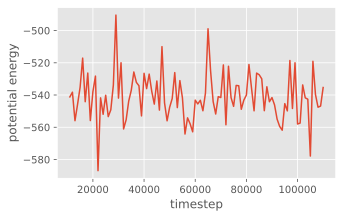

In [18]:
timestep = data['configuration/step']
potential_energy = data[
    'log/md/compute/ThermodynamicQuantities/potential_energy']

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(timestep, potential_energy)
ax.set_xlabel('timestep')
ax.set_ylabel('potential energy')
fig

In this section, you have logged quantities to a GSD file during a simulation run and analyzed that data as a time series.
The next section of this tutorial shows you how to save per-particle quantities associated with specific system configurations.

[Index](00-index.ipynb) / [Next section](02-Saving-Array-Quantities.ipynb).